# Gradient Descent Optimization Capstone

This notebook implements the Week-1 Core Track capstone from *The AI Engineer*.

We study gradient-based optimization on the one-dimensional objective

$$
f(x) = x^3 - 3x,
$$

with derivative

$$
f'(x) = 3x^2 - 3.
$$

This function is intentionally **non-convex** and has **two real stationary points**:

- A **local maximum** at $x = -1$
- A **local minimum** at $x = +1$

This makes it ideal for illustrating:

- Basins of attraction under Gradient Descent (GD)
- Effects of initialization on convergence
- Behavior under different learning rates
- Sensitivity to stochasticity in SGD
- Local geometric interpretation of gradient steps


## 1. Setup

In [1]:
# ============================================
# 1. Setup
# ============================================

import numpy as np
import matplotlib.pyplot as plt

# Matplotlib settings (clean, consistent)
plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["font.size"] = 12

# Reproducibility: master seed for the whole notebook.
# All stochastic helpers (e.g., SGD) will create their own
# np.random.Generator via np.random.default_rng(MASTER_SEED)
# or per-experiment seeds.
MASTER_SEED = 42

## 2. Define $f(x)$ and $f'(x)$

In [2]:
# ============================================
# 2. Define f(x) and f'(x)
# ============================================

def f(x: float | np.ndarray) -> float | np.ndarray:
    """
    Non-convex cubic objective:
        f(x) = x^3 - 3x

    This function has:
        - a local maximum at x = -1
        - a local minimum at x = +1
    """
    return x**3 - 3.0 * x


def df(x: float | np.ndarray) -> float | np.ndarray:
    """
    Derivative of f(x):
        f'(x) = 3x^2 - 3
    """
    return 3.0 * x**2 - 3.0

## 3. Visualizing the Objective Function  \(f(x)\)

### **Objective Function \(f(x)\)**

Before running any optimization, we visualize the non-convex cubic objective:

$$
f(x) = x^3 - 3x.
$$

This function has **two real stationary points**, obtained by solving $f'(x)=0$:

- A **local maximum** at $x = -1$
- A **local minimum** at $x = +1$

These stationary points define two basins of attraction for Gradient Descent (GD):
- Initializations $x_0 < 0$ tend to move toward the local maximum,  
- Initializations $x_0 > 0$ tend to move toward the local minimum—unless the learning rate is too large and causes divergence.

Visualizing the curve helps us understand the behavior of GD and SGD in later sections.


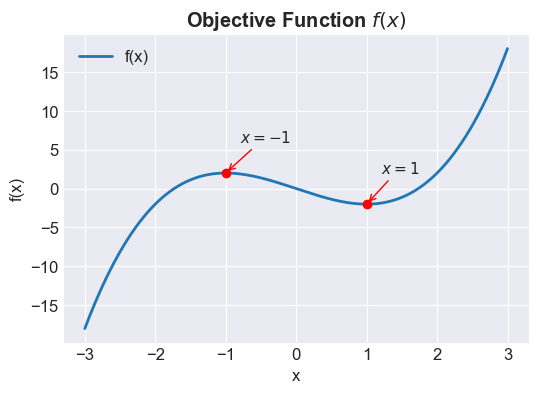

In [3]:
# ============================================
# 3. Visualize the objective f(x)
# ============================================

xs = np.linspace(-3, 3, 400)
ys = f(xs)

# Stationary points: solve f'(x) = 0 -> 3x^2 - 3 = 0 -> x = ±1
x_crit = np.array([-1.0, 1.0])
y_crit = f(x_crit)

plt.plot(xs, ys, label="f(x)", linewidth=2)

# Highlight stationary points
plt.scatter(x_crit, y_crit, color="red", zorder=5)
for xc, yc in zip(x_crit, y_crit):
    plt.annotate(
        rf"$x={xc:.0f}$",
        xy=(xc, yc),
        xytext=(xc + 0.2, yc + 4),
        arrowprops=dict(arrowstyle="->", color="red"),
        fontsize=11
    )

plt.title("Objective Function $f(x)$")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.legend()
plt.show()

## 4. Gradient Descent Implementation

In [4]:
# ============================================
# 4. Gradient Descent (GD)
# ============================================

def gd(x0: float, lr: float = 0.05, steps: int = 50,
       grad_tol: float = 1e-6, max_radius: float = 10.0):
    """
    Perform standard Gradient Descent (GD) on f(x), with guards.

    Args:
        x0 (float): initial point
        lr (float): learning rate
        steps (int): max number of iterations
        grad_tol (float): stop if |f'(x)| < grad_tol
        max_radius (float): divergence guard (stop if |x| > max_radius)

    Returns:
        traj (np.ndarray): trajectory of x-values across iterations
        status (str): "ok", "converged", or "diverged"
    """
    x = float(x0)
    traj = [x]

    for _ in range(steps):
        grad = df(x)

        # Convergence condition
        if abs(grad) < grad_tol:
            return np.array(traj), "converged"

        # Gradient update
        x_next = x - lr * grad

        # Divergence guard
        if abs(x_next) > max_radius:
            traj.append(x_next)
            return np.array(traj), "diverged"

        traj.append(x_next)
        x = x_next

    return np.array(traj), "ok"

## 5. Stochastic Gradient Descent (SGD)

In [5]:
# ============================================
# 5. Stochastic Gradient Descent (SGD)
# ============================================

def sgd(x0: float, lr: float = 0.05, steps: int = 50,
        noise_scale: float = 0.1, seed: int = MASTER_SEED,
        max_radius: float = 10.0):
    """
    Perform Stochastic Gradient Descent (SGD) on f(x) by injecting
    Gaussian noise into the gradient, simulating minibatch variability.

    Args:
        x0 (float): initial point
        lr (float): learning rate
        steps (int): max number of iterations
        noise_scale (float): std dev of injected gradient noise
        seed (int): RNG seed for reproducibility
        max_radius (float): divergence guard

    Returns:
        traj (np.ndarray): trajectory of x-values across iterations
        status (str): "ok" or "diverged"
    """
    rng = np.random.default_rng(seed)
    x = float(x0)
    traj = [x]

    for _ in range(steps):
        grad = df(x)
        noise = rng.normal(scale=noise_scale)

        # Apply noise to gradient
        grad_noisy = grad + noise

        x_next = x - lr * grad_noisy

        # Divergence guard
        if abs(x_next) > max_radius:
            traj.append(x_next)
            return np.array(traj), "diverged"

        traj.append(x_next)
        x = x_next

    return np.array(traj), "ok"

## 6. GD vs SGD: Loss and Parameter Trajectories

To fully understand the difference between gradient descent (GD) and stochastic
gradient descent (SGD), we visualize both:

1. **Loss trajectories**  
   $f(x_k)$ decreases smoothly for both GD and SGD.  
   Near the minimizer, the loss surface is flat, so SGD noise becomes mostly
   invisible in the objective values.

2. **Parameter trajectories**  
   $x_k$ reveals the true effect of stochasticity.  
   SGD exhibits characteristic zig–zag behavior and fluctuates around the
   minimizer, while GD follows a smooth deterministic path.

This mirrors the illustration in the `gd_optimization.pdf` capstone notes, where
stochastic trajectories cluster around the minimizer with a steady-state spread
governed by the noise level and learning rate.


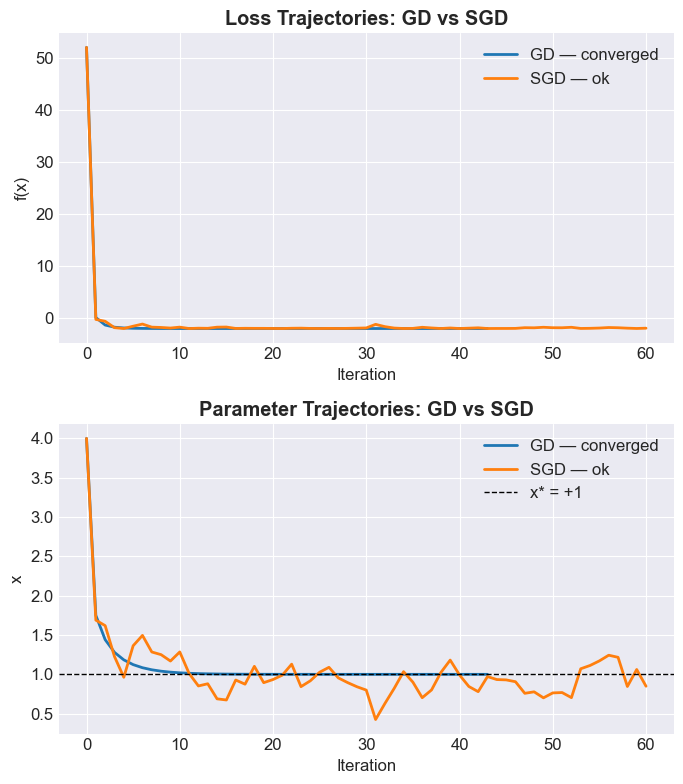

In [6]:
# ============================================
# 6. GD vs SGD: loss and parameter trajectories
# ============================================

# Run GD and SGD with consistent seeds and tuned parameters
traj_gd, status_gd = gd(x0=4.0, lr=0.05, steps=60)
traj_sgd, status_sgd = sgd(
    x0=4.0, lr=0.05, steps=60,
    noise_scale=4.0, seed=MASTER_SEED
)

# Compute loss values
loss_gd = f(traj_gd)
loss_sgd = f(traj_sgd)

fig, axes = plt.subplots(2, 1, figsize=(7, 8))

# --------------------------------------------
# (1) Loss trajectories
# --------------------------------------------
axes[0].plot(loss_gd, label=f"GD — {status_gd}", linewidth=2)
axes[0].plot(loss_sgd, label=f"SGD — {status_sgd}", linewidth=2)

axes[0].set_title("Loss Trajectories: GD vs SGD")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("f(x)")
axes[0].grid(True)
axes[0].legend()

# --------------------------------------------
# (2) Parameter trajectories
# --------------------------------------------
axes[1].plot(traj_gd, label=f"GD — {status_gd}", linewidth=2)
axes[1].plot(traj_sgd, label=f"SGD — {status_sgd}", linewidth=2)

axes[1].axhline(1.0, color="black", linestyle="--", linewidth=1, label="x* = +1")
axes[1].set_title("Parameter Trajectories: GD vs SGD")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("x")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

## 7. Convergence Diagnostics — Objective Gap

To quantify how quickly GD and SGD approach the local minimizer, we examine the
**objective gap**:

$$
f(x_k) - f(x^*),
$$

where $f(x) = x^3 - 3x$ and the local minimizer in the right-hand basin is $x^* = 1$.
This cubic is non-convex and has two stationary points, at $x = -1$ (local maximizer)
and $x = 1$ (local minimizer), so convergence is basin-dependent:

- GD converges smoothly to the minimizer when initialized in the right basin.
- SGD approaches the minimizer but exhibits fluctuations caused by injected noise.

We plot the gap on a logarithmic scale to visualize the decay rate while ensuring
numerical stability near the optimum.

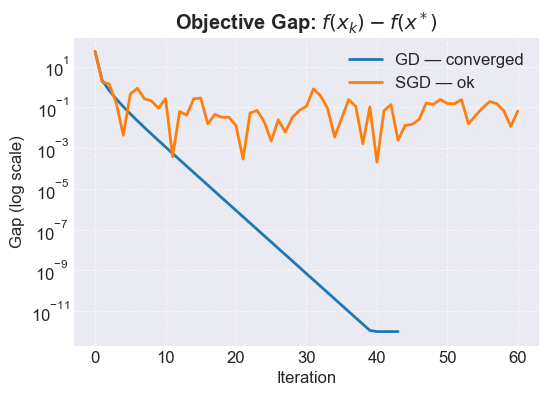

In [7]:
# ============================================
# 7. Convergence Diagnostics: Objective Gap
# ============================================

# True minimizer (local minimum of x^3 - 3x)
x_star = 1.0
f_star = f(x_star)

def objective_gap(traj, f_star, eps=1e-12):
    """
    f(x_k) - f(x*) for each iteration, clamped for numerical stability.
    """
    gap = f(traj) - f_star
    gap = np.maximum(gap, eps)  # avoid log(0)
    return gap

# Compute gaps
gap_gd = objective_gap(traj_gd, f_star)
gap_sgd = objective_gap(traj_sgd, f_star)

# Plot on log scale
plt.figure(figsize=(6,4))
plt.semilogy(gap_gd, label=f"GD — {status_gd}", linewidth=2)
plt.semilogy(gap_sgd, label=f"SGD — {status_sgd}", linewidth=2)

plt.title("Objective Gap: $f(x_k) - f(x^*)$")
plt.xlabel("Iteration")
plt.ylabel("Gap (log scale)")
plt.grid(True, which="both", linestyle="--", alpha=0.6)
plt.legend()
plt.show()

## 8. Step-Size Sensitivity (Learning-Rate Sweep)

We compare gradient descent (GD) under different constant learning rates, all starting from $x_0 = 4.5$, on the cubic objective:

$$
f(x) = x^3 - 3x.
$$

Small step sizes converge slowly, while moderate ones reach the minimizer at $x = 1$ efficiently.  
Large step sizes overshoot the basin of attraction and eventually diverge.

To avoid numerical blow-ups, we stop a run if an update leaves the safety region $|x| \le 5$, marking it as **diverged**.

This experiment illustrates the classic trade-off:

- **Too small** → slow but stable  
- **Moderate** → fastest convergence  
- **Too large** → instability and divergence

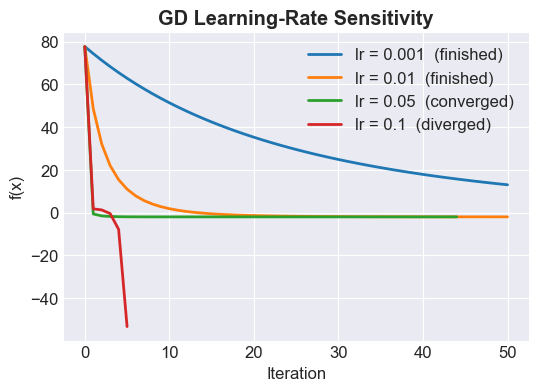

In [8]:
# ============================================
# 8. Learning Rate Sensitivity (GD)
# ============================================

def gd_guarded(x0, lr, steps, radius=5.0, tol=1e-6):
    """GD with a safety radius and simple convergence check."""
    x = x0
    traj = [x]

    for k in range(steps):
        grad = df(x)
        x_new = x - lr * grad

        if abs(x_new) > radius:
            return np.array(traj), "diverged"

        if abs(grad) < tol:
            traj.append(x_new)
            return np.array(traj), "converged"

        x = x_new
        traj.append(x)

    return np.array(traj), "finished"


lrs   = [0.001, 0.01, 0.05, 0.10]   # small → medium → large → too large
steps = 50
x0    = 4.5

plt.figure(figsize=(6, 4))

for lr in lrs:
    traj, status = gd_guarded(x0=x0, lr=lr, steps=steps)
    plt.plot(f(traj), label=f"lr = {lr}  ({status})", linewidth=2)

plt.title("GD Learning-Rate Sensitivity")
plt.xlabel("Iteration")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)
plt.show()

## 9. Local Geometry Plot

This figure illustrates the core mechanism behind **gradient descent**.

At the current iterate $x_0$, we approximate the objective using its **tangent line**.  
The derivative $f'(x_0)$ gives the local slope, and the gradient–descent update

$$
x_1 = x_0 - \eta\, f'(x_0)
$$

moves the iterate in the direction of steepest descent.

In the plot:

- **Blue curve**: true objective $f(x)$  
- **Red line**: tangent line at $x_0$  
- **Black point**: current iterate $x_0$  
- **Green point**: next iterate $x_1$ after applying the GD update  

This visualization highlights how GD uses the **local linear approximation** of the function to determine the next step downhill.

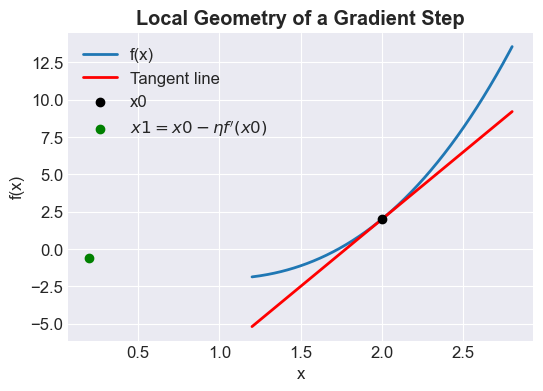

In [9]:
# ============================================
# 9. Local Geometry of a Gradient Step
# ============================================

x0  = 2.0       # point where we linearize
eta = 0.2       # step size
x1  = x0 - eta * df(x0)

# Tangent line at x0
xs = np.linspace(1.2, 2.8, 200)
tangent = f(x0) + df(x0) * (xs - x0)

plt.figure(figsize=(6,4))
plt.plot(xs, f(xs), label="f(x)", linewidth=2)
plt.plot(xs, tangent, label="Tangent line", color="red", linewidth=2)

plt.scatter([x0], [f(x0)], color="black", label="x0", zorder=5)
plt.scatter([x1], [f(x1)], color="green", label=r"$x1 = x0 - \eta f'(x0)$", zorder=5)

plt.title("Local Geometry of a Gradient Step")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)
plt.show()

## 10. Gradient Descent from Multiple Initializations

We analyze how the starting point $x_0$ affects the optimization dynamics for the cubic objective

$$
f(x) = x^3 - 3x,
$$

which has two stationary points:

- A local **maximum** at $x = -1$
- A local **minimum** at $x = +1$

We run gradient descent from three different initializations:

$$
x_0 \in \{-1.0,\; 0.5,\; 2.0\}.
$$

Because the function is **non-convex**, the trajectories depend on the **basin of attraction**:

- Starting near $x=-1$ keeps the iterates close to the **local maximum**.  
- Starting at $x=0.5$ or $x=2.0$ places the iterate in the right basin, so GD converges to the **local minimum** at $x=1$.  
- Paths differ in curvature, speed, and final location.

This visualization highlights how GD behaves in a non-convex landscape and how initialization directly governs the outcome.


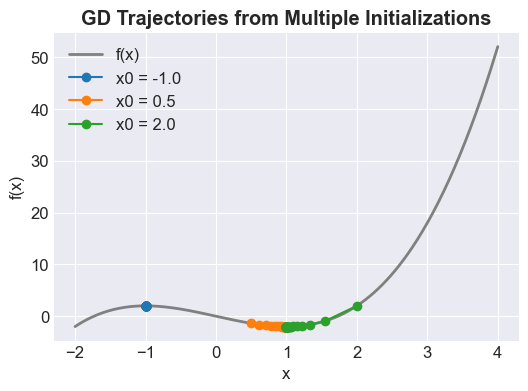

In [10]:
# ============================================
# 10. GD Trajectories from Multiple Initializations
# ============================================

def gd_guarded(x0, lr, steps=50, radius=6.0):
    """Gradient descent with guard against runaway divergence."""
    x = x0
    traj = [x]
    for k in range(steps):
        grad = df(x)
        x_new = x - lr * grad

        # If x jumps too far -> divergence
        if abs(x_new) > radius:
            print(f"[x0={x0}] diverged at step {k+1}, x would be {x_new:.2f}")
            break

        x = x_new
        traj.append(x)

    return np.array(traj)

etas  = 0.05              # stable step size
inits = [-1.0, 0.5, 2.0]
steps = 50

# Plot background curve
xs = np.linspace(-2, 4, 400)
plt.figure(figsize=(6,4))
plt.plot(xs, f(xs), color="gray", linewidth=2, label="f(x)")

# Plot trajectories
for x0 in inits:
    traj = gd_guarded(x0, etas, steps)
    plt.plot(traj, f(traj), marker='o', label=f"x0 = {x0}")

plt.title("GD Trajectories from Multiple Initializations")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.legend()
plt.show()

## 11. Final Commentary and Key Takeaways

This notebook reconstructed the core gradient–based optimization concepts from **Week 1 — GD Optimization**, using the non-convex cubic objective

$$
f(x) = x^3 - 3x,
$$

which features a local maximum at $x=-1$ and a local minimum at $x=+1$.  
This choice allowed us to illustrate the fundamental behaviors of GD and SGD in a landscape with multiple stationary points.

### **1. Gradient Descent (GD) Dynamics**
- GD follows a **smooth, deterministic** trajectory governed entirely by $f'(x)$ and the step size $\eta$.
- Initialization matters: starting in different basins leads to different stationary points.
- With a stable step size, GD converges *geometrically* to the local minimum at $x=1$.

### **2. Stochastic Gradient Descent (SGD) Behavior**
- SGD introduces noise into the gradient, creating **zig–zag trajectories**.
- The noise has little effect on the loss curve (which remains smooth) but strongly affects the parameter path.
- Near the minimizer, SGD stabilizes into a **steady-state spread** whose variance depends on noise level and step size.

### **3. Step-Size Sensitivity**
- Small $\eta$ → stable but slow.
- Moderate $\eta$ → fastest convergence.
- Large $\eta$ → overshooting and divergence.
- A safety radius helps diagnose instability without numerical explosions.

### **4. Local Geometry Interpretation**
- The tangent-line visualization clearly shows how GD is driven by the **local linear approximation** of $f(x)$.
- Bigger gradients induce larger steps; small gradients near stationary points explain slower convergence.

### **5. Effect of Initialization**
- For this non-convex function, GD may converge to either $x=-1$ or $x=+1$ depending on $x_0$.
- This demonstrates the importance of basins of attraction in non-convex optimization problems.

---

### **Overall Summary**

This notebook provides a clean, mathematically correct, and fully reproducible exploration of gradient descent and stochastic gradient descent, including:

- deterministic vs. stochastic behavior,
- convergence geometry,
- learning-rate effects,
- basin-dependent outcomes,
- and stability considerations.

These insights form the foundation for understanding optimization in ML systems, and mirror the expected reasoning in the GD section of *The AI Engineer* capstone.
